In [99]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import silhouette_score, accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [67]:
RANDOM_STATE = 42

## I. Data Import & Initial Anaysis

#### a. Structure: Training dataset

In [ ]:
## customer_raw.csv file loaded
df = pd.read_csv('../customers_raw.csv')

print(f'Shape: {df.shape}')
print('\n')

print(df.info())
print('\n')

df.head()

Shape: (5142, 21)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5142 entries, 0 to 5141
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           5142 non-null   object 
 1   Account Length  5142 non-null   int64  
 2   Area Code       5142 non-null   int64  
 3   Phone           5142 non-null   object 
 4   Int'l Plan      5142 non-null   object 
 5   VMail Plan      5142 non-null   object 
 6   VMail Message   5142 non-null   int64  
 7   Day Mins        5142 non-null   float64
 8   Day Calls       5142 non-null   int64  
 9   Day Charge      5142 non-null   float64
 10  Eve Mins        5142 non-null   float64
 11  Eve Calls       5142 non-null   int64  
 12  Eve Charge      5142 non-null   float64
 13  Night Mins      5142 non-null   float64
 14  Night Calls     5142 non-null   int64  
 15  Night Charge    5142 non-null   float64
 16  Intl Mins       5142 non-null   float64
 17  Intl Calls   

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [69]:
## Missing values
print(df.isnull().sum())

State                0
Account Length       0
Area Code            0
Phone                0
Int'l Plan           0
VMail Plan           0
VMail Message        0
Day Mins             0
Day Calls            0
Day Charge           0
Eve Mins             0
Eve Calls            0
Eve Charge           0
Night Mins           0
Night Calls          0
Night Charge         0
Intl Mins            0
Intl Calls           0
Intl Charge          0
CustServ Calls       0
Churn?            1809
dtype: int64


The rows with missing values in the target column are going to be separated to create the training dataset and the dataset where we will map our final model.

In [70]:
training_df = df[df['Churn?'].notnull()]

print(f'Shape: {training_df.shape}')
print('\n')

training_df.head()

Shape: (3333, 21)




,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


#### b. Vizualisations

<Axes: ylabel='count'>

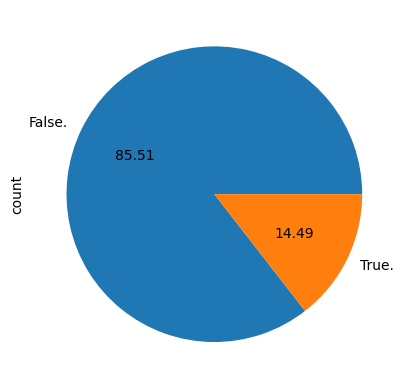

In [71]:
## Class repartition
training_df['Churn?'].value_counts().plot.pie(autopct='%.2f')

The class distribution within the target column shows an imbalanced training dataset. Later, we will address this issue to improve the model's fit.

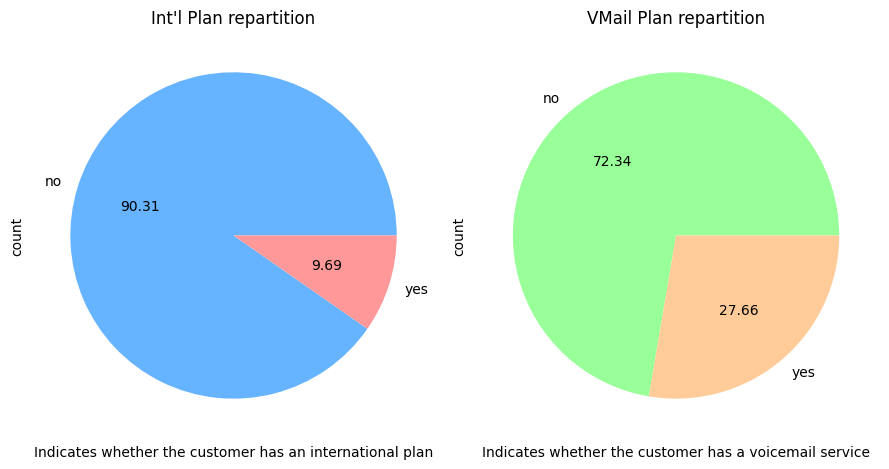

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))

training_df["Int'l Plan"].value_counts().plot.pie(autopct='%.2f', colors = ['#66b3ff', '#ff9999'], ax=axes[0])
axes[0].set_title("Int'l Plan repartition")
axes[0].set_xlabel('Indicates whether the customer has an international plan')

training_df['VMail Plan'].value_counts().plot.pie(autopct='%.2f', colors = ['#99ff99', '#ffcc99'], ax=axes[1])
axes[1].set_title('VMail Plan repartition')
axes[1].set_xlabel('Indicates whether the customer has a voicemail service')

plt.tight_layout()
plt.show()

In [73]:
training_df.columns

Index(['State', 'Account Length', 'Area Code', 'Phone', 'Int'l Plan',
       'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge',
       'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls',
       'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge',
       'CustServ Calls', 'Churn?'],
      dtype='object')

## II. Data Cleaning & Preparation

#### a.1 Categorical features

We start with a binary encoding of categorical features.

In [74]:
training_df.select_dtypes(exclude = np.number).head()

,State,Phone,Int'l Plan,VMail Plan,Churn?
0,KS,382-4657,no,yes,False.
1,OH,371-7191,no,yes,False.
2,NJ,358-1921,no,no,False.
3,OH,375-9999,yes,no,False.
4,OK,330-6626,yes,no,False.


In [75]:
training_df = training_df.drop(columns=['Phone'])

training_df["Int'l Plan"] = [0 if x == 'no' else 1 for x in training_df["Int'l Plan"]]
training_df['VMail Plan'] = [0 if x == 'no' else 1 for x in training_df['VMail Plan']]
training_df['Churn?'] = [0 if x == 'False.' else 1 for x in training_df['Churn?']]

We drop the Phone column because it is not relevant for training the model. It could generate noise, as this format of phone number does not provide any geolocation information or anything else.

In [76]:
training_df.head()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


#### b.1 Numerical features - outliers

In [77]:
training_df.select_dtypes(include = np.number).describe()

,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,42.371290,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,415.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,510.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,510.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


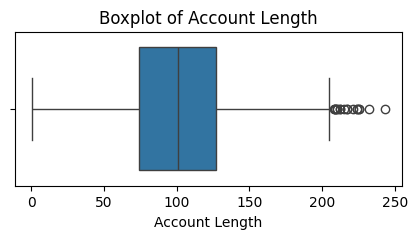

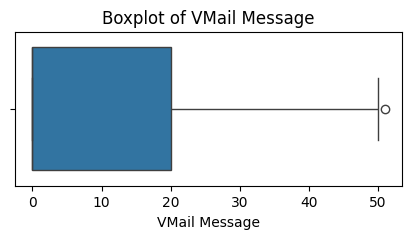

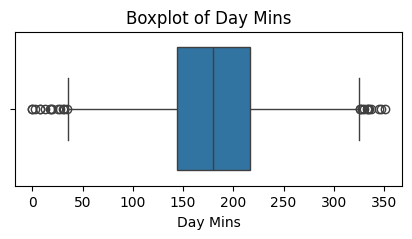

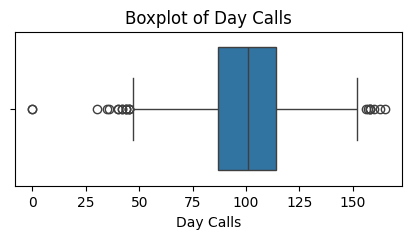

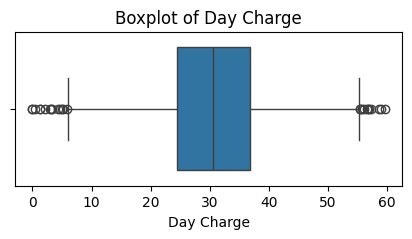

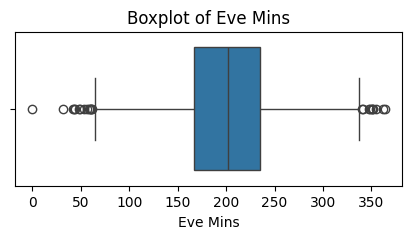

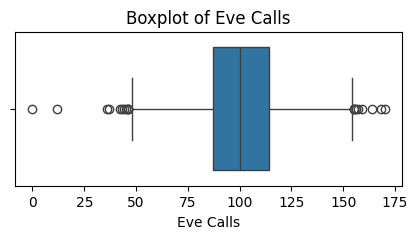

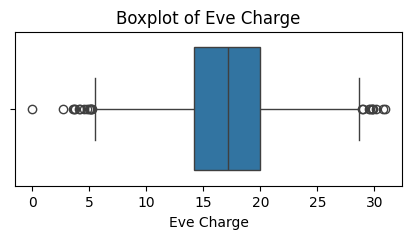

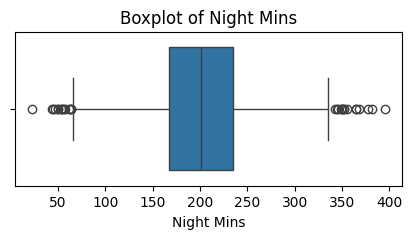

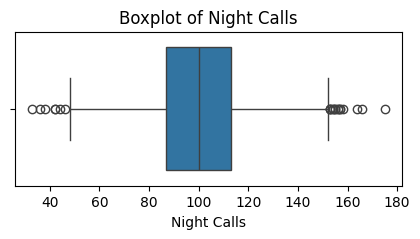

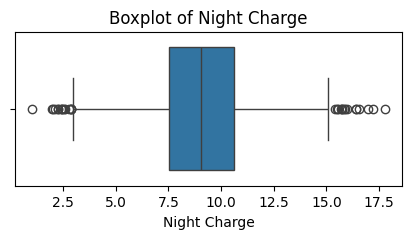

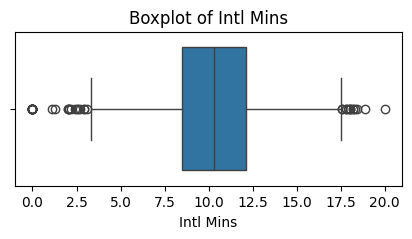

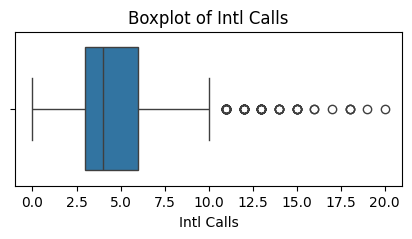

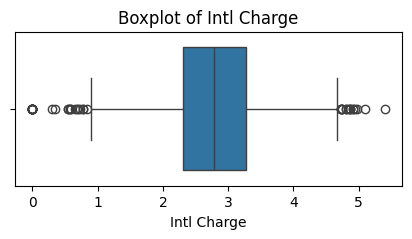

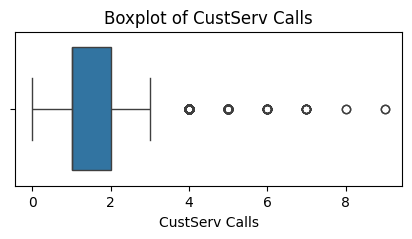

In [78]:
for column in df.select_dtypes(include = np.number).columns:

  if column in ['Area Code', "Int'l Plan", 'VMail Plan', 'Churn?']:
    pass

  else:
    plt.figure(figsize=(5, 2))
    sns.boxplot(x = training_df[column])
    plt.title(f"Boxplot of {column}")
    plt.show()

#### b.2 Numerical features

In [79]:
normalized_df = training_df.copy()

for i in training_df.columns:
  if i != 'State':
    normalized_df[i] = (normalized_df[i] - normalized_df[i].min()) / (normalized_df[i].max() - normalized_df[i].min())

normalized_df.head()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,0.524793,0.068627,0.0,1.0,0.490196,0.755701,0.666667,0.755701,0.542755,0.582353,0.542866,0.595750,0.408451,0.595935,0.500,0.15,0.500000,0.111111,0.0
1,OH,0.438017,0.068627,0.0,1.0,0.509804,0.460661,0.745455,0.460597,0.537531,0.605882,0.537690,0.621840,0.492958,0.622236,0.685,0.15,0.685185,0.111111,0.0
2,NJ,0.561983,0.068627,0.0,0.0,0.000000,0.693843,0.690909,0.693830,0.333242,0.647059,0.333225,0.374933,0.500000,0.375374,0.610,0.25,0.609259,0.000000,0.0
3,OH,0.342975,0.000000,1.0,0.0,0.000000,0.853478,0.430303,0.853454,0.170195,0.517647,0.170171,0.467187,0.394366,0.467424,0.330,0.35,0.329630,0.222222,0.0
4,OK,0.305785,0.068627,1.0,0.0,0.000000,0.475200,0.684848,0.475184,0.407754,0.717647,0.407959,0.440290,0.619718,0.440526,0.505,0.15,0.505556,0.333333,0.0


Normalization of numerical data is a relevant process to train certain models like k-nearest neighbors.

#### b. Define y & X

First, we create a training feature dataset X where we will encode the values of the categorical column 'State', and then we create the target column y.

In [80]:
## Without normalization
X = training_df.drop(columns = ['Churn?'])
X = pd.get_dummies(X, columns = ['State']).astype(int)
print(f"Shape X: {X.shape}")

y = training_df['Churn?']
print(f"Shape y: {y.shape}")

Shape X: (3333, 69)
Shape y: (3333,)


Same process with normalized data (y = y_norm)

In [81]:
## With normalization
X_norm = normalized_df.drop(columns = ['Churn?'])
X_norm = pd.get_dummies(X_norm, columns = ['State']).astype(int)
print(f"Shape X_norm: {X_norm.shape}")

y_norm = normalized_df['Churn?']
print(f"Shape y_norm: {y_norm.shape}")

Shape X_norm: (3333, 69)
Shape y_norm: (3333,)


In order to optimize the model, we check if it's possible to optimize the number of training parameters by visualizing the pairwise correlations between features.

In [82]:
## Sight on features correlation after pre-processing and features encoding
corr_df = X.copy()
corr_df['Churn?'] = y

corr = corr_df.corr()

fig = px.imshow(corr.values, x = corr.columns, y = corr.index)
fig.update_layout(width = 500, height = 500)
fig.show()

Features with high positive or negative correlation can be simplified.

The correlation threshold can be manually chosen by the user.

In [83]:
treshold_corr = 0.7

corr_long = corr.where(np.triu(np.ones(corr.shape).astype(bool), k=1)).stack().reset_index()
corr_long.columns = ['parameter1', 'parameter2', 'correlation_score']

high_corr_df = corr_long[abs(corr_long['correlation_score']) > treshold_corr]

high_corr_df = high_corr_df.sort_values(by = 'correlation_score', ascending = False)

print(f"{len(high_corr_df)} features have high absolute correlation")
print('\n')
high_corr_df

5 features have high absolute correlation




,parameter1,parameter2,correlation_score
336,Day Mins,Day Charge,0.999511
525,Eve Mins,Eve Charge,0.997676
705,Night Mins,Night Charge,0.992193
204,VMail Plan,VMail Message,0.956927
876,Intl Mins,Intl Charge,0.927339


## III. Unsupervised Learning: Customer Clustering

#### a. First attempt

First model training as a baseline for initial calibration, using a classification with the linear regression algorithm.

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)

model = LogisticRegression(max_iter = 10000, random_state = RANDOM_STATE)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred),2)}")
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.86


              precision    recall  f1-score   support

           0       0.87      0.98      0.92       566
           1       0.61      0.20      0.30       101

    accuracy                           0.86       667
   macro avg       0.74      0.59      0.61       667
weighted avg       0.83      0.86      0.83       667



The goal is to predict churn, which means class 1. Therefore, we must focus on the prediction scores for class 1.

#### b.1 Customer Clustering

To improve the training of our model, we can apply reinforcement learning to our training data to create a new column that will serve as a segmentation, providing additional information for our classification model. We can use Kmeans to generate clusters. We are using two methods to find the optimal number of cluster.

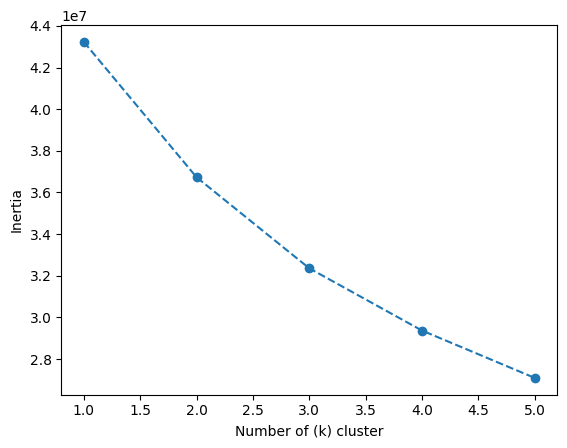

In [85]:
inertia = []
k_values = range(1, 6)

for k in range(1, 6):
    kmeans = KMeans(n_clusters = k, random_state = RANDOM_STATE, n_init = 10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Number of (k) cluster')
plt.ylabel('Inertia')
plt.show()

The elbow method shows that the curve's inclination becomes less prominent at k = 3.

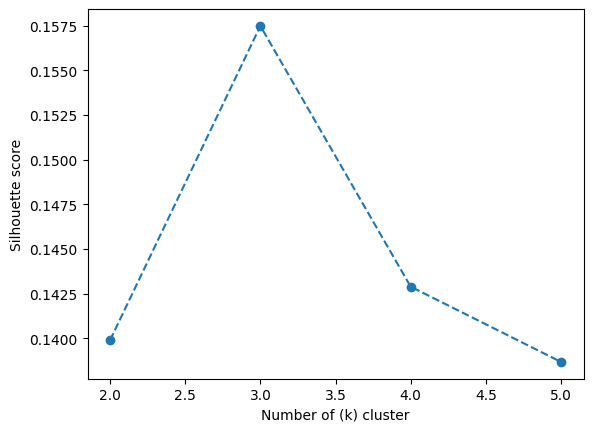

In [86]:
range_k = range(2, 6)
silhouette_scores = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.plot(range_k, silhouette_scores, marker = 'o', linestyle = '--')
plt.xlabel('Number of (k) cluster')
plt.ylabel('Silhouette score')
plt.show()

Same conclusion with the silhouette method.

In [87]:
## Cluster column addition
n_clusters = 3

kmeans = KMeans(n_clusters = n_clusters, random_state=42)
kmeans.fit(X)

labels = kmeans.predict(X)

X['Cluster'] = labels

We integrate the new feature 'cluster' into our dataset X, with integer values ranging from 0 to 2.

#### b.2 Attempt with Cluster feature

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)

model = LogisticRegression(max_iter = 10000, random_state = RANDOM_STATE)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred),2)}")
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.86


              precision    recall  f1-score   support

           0       0.87      0.98      0.92       566
           1       0.58      0.19      0.28       101

    accuracy                           0.86       667
   macro avg       0.72      0.58      0.60       667
weighted avg       0.83      0.86      0.82       667



The results show that the prediction scores for class 1 are lower than those without the feature. However, the overall accuracy remains the same. This means that the model performs slightly better on class 0, which is not what we want. In this case, we have reinforced learning for the wrong class. To address this, we will adjust the class proportions in our training dataset.

## IV. Supervised Learning: Churn Prediction

#### a. Dealing with Imbalenced Dataset using SMOTE

We will use the SMOTE algorithm to generate new entries in our training dataset from the existing data of the minority class (class 1). This will improve the class balance for training. The parameter k_neighbors can be chosen by the user. This parameter has influence on final results.

In [89]:
k_neighbors = 7

smote = SMOTE(sampling_strategy='auto', random_state = RANDOM_STATE, k_neighbors = k_neighbors)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

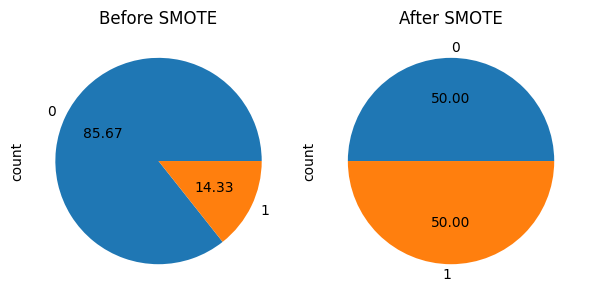

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(6, 6))

y_train.value_counts().plot.pie(autopct='%.2f', ax=axes[0])
axes[0].set_title("Before SMOTE")

y_train_smote.value_counts().plot.pie(autopct='%.2f', ax=axes[1])
axes[1].set_title("After SMOTE")

plt.tight_layout()
plt.show()

#### b.1 Linear Regression on balanced data

In [91]:
model = LogisticRegression(max_iter = 10000, random_state = RANDOM_STATE)
model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred),2)}")
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.85


              precision    recall  f1-score   support

           0       0.88      0.95      0.91       566
           1       0.51      0.29      0.37       101

    accuracy                           0.85       667
   macro avg       0.70      0.62      0.64       667
weighted avg       0.83      0.85      0.83       667



In our case, the important metric is Recall, as it represents the ability to identify positive cases, meaning churners. After applying SMOTE (and clustering), we achieved a Recall of 0.29 (compared to 0.21 before and without clustering). This is a significant first improvement.

#### b.2 Models on balanced data

Now, we will test different stronger classification models.

In [92]:
models = [DecisionTreeClassifier(random_state = RANDOM_STATE),
          RandomForestClassifier(random_state = RANDOM_STATE),
          xgb.XGBClassifier(random_state = RANDOM_STATE),
          KNeighborsClassifier()
          ]

for model in models:

    print(f"{model.__class__.__name__}")
    print('\n')

    model.fit(X_train_smote, y_train_smote)
    cross_val_score(model, X, y, cv=5)
    y_pred = model.predict(X_test)

    print(f"Accuracy: {round(accuracy_score(y_test, y_pred),2)}")
    print(classification_report(y_test, y_pred))
    print('-' * 60)

DecisionTreeClassifier


Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       566
           1       0.51      0.71      0.59       101

    accuracy                           0.85       667
   macro avg       0.73      0.79      0.75       667
weighted avg       0.88      0.85      0.86       667

------------------------------------------------------------
RandomForestClassifier


Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       566
           1       0.80      0.65      0.72       101

    accuracy                           0.92       667
   macro avg       0.87      0.81      0.84       667
weighted avg       0.92      0.92      0.92       667

------------------------------------------------------------
XGBClassifier


Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       566
    

The KNeighborsClassifier is a simple model based on the proximity of neighbors, while DecisionTree, RandomForest, and XGBClassifier build more complex models that are better at capturing non-linear relationships in the data, but require more training time and are less interpretable.

The scores have increased overall, with XGBoost showing very good results both globally and in recall.

#### c. Models training on normalized data

We are going to test the models on our normalized training data.

In [93]:
n_clusters = 3

kmeans = KMeans(n_clusters = n_clusters, random_state=42)
kmeans.fit(X)

labels = kmeans.predict(X)

X_norm['Cluster'] = labels

X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y_norm, test_size = 0.2, random_state = RANDOM_STATE)

smote = SMOTE(sampling_strategy='auto', random_state = RANDOM_STATE, k_neighbors = 7)
X_norm_train_smote, y_norm_train_smote = smote.fit_resample(X_norm_train, y_norm_train)

models = [DecisionTreeClassifier(random_state = RANDOM_STATE),
          RandomForestClassifier(random_state = RANDOM_STATE),
          xgb.XGBClassifier(random_state = RANDOM_STATE),
          KNeighborsClassifier()
          ]

for model in models:
    print(f"{model.__class__.__name__}")
    print('\n')

    model.fit(X_norm_train_smote, y_norm_train_smote)
    cross_val_score(model, X_norm, y_norm, cv=5)
    y_pred = model.predict(X_norm_test)

    print(f"Accuracy: {round(accuracy_score(y_norm_test, y_pred),2)}")
    print(classification_report(y_norm_test, y_pred))
    print('-' * 20, '[NORMALIZED DATA]','-' * 20)


DecisionTreeClassifier


Accuracy: 0.75
              precision    recall  f1-score   support

         0.0       0.88      0.83      0.85       566
         1.0       0.26      0.35      0.30       101

    accuracy                           0.75       667
   macro avg       0.57      0.59      0.57       667
weighted avg       0.78      0.75      0.77       667

-------------------- [NORMALIZED DATA] --------------------
RandomForestClassifier


Accuracy: 0.72
              precision    recall  f1-score   support

         0.0       0.88      0.78      0.83       566
         1.0       0.25      0.41      0.31       101

    accuracy                           0.72       667
   macro avg       0.56      0.59      0.57       667
weighted avg       0.78      0.72      0.75       667

-------------------- [NORMALIZED DATA] --------------------
XGBClassifier


Accuracy: 0.73
              precision    recall  f1-score   support

         0.0       0.88      0.78      0.83       566
      

Usually, KNeighborsClassifier is quite sensitive to normalized data. The other models tested should not be too sensitive either. However, due to the small amount of data and the tight concentration (small std deviation), data normalization decreases the score.

## V. Feature Engineering & Hyperparameter Tuning

#### a. Reducing the number of features based on correlation

We will now observe the impact on our metrics of simplifying our training dataset in terms of the number of features.

In [94]:
high_corr_df

,parameter1,parameter2,correlation_score
336,Day Mins,Day Charge,0.999511
525,Eve Mins,Eve Charge,0.997676
705,Night Mins,Night Charge,0.992193
204,VMail Plan,VMail Message,0.956927
876,Intl Mins,Intl Charge,0.927339


First, we will remove one of the two components from each pair of features that are absolutely correlated above the threshold entered, and then remove the other component to observe the impact on the results.

In [ ]:
for i in high_corr_df.columns[:-1]:

  print(f"{'-' * 20} [{i} SIMPLIFICATION] {'-' * 20}")

  simplify_df = X.drop(columns = high_corr_df[i].unique().tolist())

  kmeans = KMeans(n_clusters = n_clusters, random_state=42)
  kmeans.fit(simplify_df)
  labels = kmeans.predict(simplify_df)
  simplify_df['Cluster'] = labels

  X_simplify_train, X_simplify_test, y_train, y_test = train_test_split(simplify_df, y, test_size = 0.2, random_state = RANDOM_STATE)

  smote = SMOTE(sampling_strategy='auto', random_state = RANDOM_STATE, k_neighbors = 7)
  X_simplify_train_smote, y_simplify_train_smote = smote.fit_resample(X_simplify_train, y_train)

  models = [RandomForestClassifier(random_state = RANDOM_STATE),
          xgb.XGBClassifier(random_state = RANDOM_STATE)]

  for model in models:

      print(f"{model.__class__.__name__}")
      print('\n')

      model.fit(X_simplify_train_smote, y_simplify_train_smote)
      cross_val_score(model, simplify_df, y, cv=5)
      y_pred = model.predict(X_simplify_test)

      print(f"Accuracy: {round(accuracy_score(y_test, y_pred),2)}")
      print(classification_report(y_test, y_pred))
      print('-' * 69)

  print('\n')

print(f"Models trained with {X_simplify_train_smote.shape[1]} parameters versus {X_train_smote.shape[1]} parameters before.")

-------------------- [parameter1 SIMPLIFICATION] --------------------
RandomForestClassifier


Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       566
           1       0.62      0.67      0.65       101

    accuracy                           0.89       667
   macro avg       0.78      0.80      0.79       667
weighted avg       0.89      0.89      0.89       667

---------------------------------------------------------------------
XGBClassifier


Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       566
           1       0.76      0.70      0.73       101

    accuracy                           0.92       667
   macro avg       0.86      0.83      0.84       667
weighted avg       0.92      0.92      0.92       667

---------------------------------------------------------------------


-------------------- [parameter2 SIMPLIFICATION] --------------

The features in the 'parameters2' column are clearly the ones that need to be simplified. The loss of information is smaller compared to that of 'parameters1'. The results for the XGBoost model are almost identical to those obtained with 5 additional features.

In [ ]:
## Removed features:
high_corr_df['parameter2'].drop_duplicates()

,parameter2
336,Day Charge
525,Eve Charge
705,Night Charge
204,VMail Message
876,Intl Charge


It would be very interesting to keep this simplification. Here, we don't have many features or rows. In order to maximize our metrics, I choose to keep the original features.

#### b. Grid Search

It is now clear that the model best suited for this task is XGBoost. We will now search for the best hyperparameters for our optimal model.

In [97]:
model = xgb.XGBClassifier(random_state = RANDOM_STATE)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = 'recall',
    cv = 5)

grid_search.fit(X_train, y_train)

print('Optimal hyperparameters:', grid_search.best_params_)
print('\n')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print('\n')
print(classification_report(y_test, y_pred))

Optimal hyperparameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100, 'subsample': 1.0}


Accuracy: 0.9580209895052474


              precision    recall  f1-score   support

           0       0.96      0.99      0.98       566
           1       0.92      0.79      0.85       101

    accuracy                           0.96       667
   macro avg       0.94      0.89      0.91       667
weighted avg       0.96      0.96      0.96       667



Here, we have tested the hyperparameters and thresholds to compare the best combination for optimizing the Recall metric, which is important for our case of maximizing True Positives.

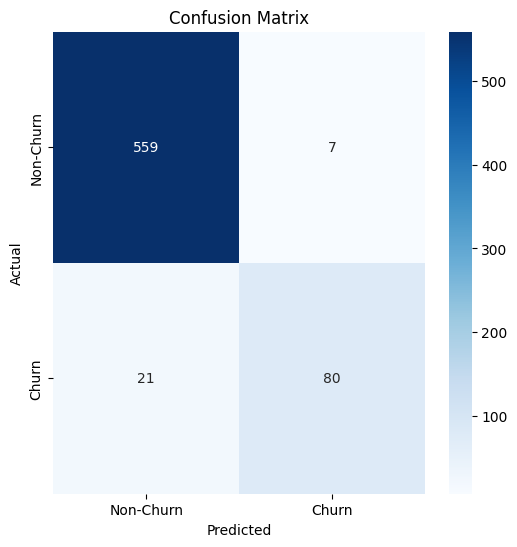

In [106]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot = True, fmt='d', cmap='Blues', xticklabels = ['Non-Churn', 'Churn'], yticklabels = ['Non-Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## VI. Results

Application of our optimal model on the unlabeled data.

In [ ]:
test_df = df[df['Churn?'].isnull()]

test_df = test_df.drop(columns=['Phone'])
test_df["Int'l Plan"] = [0 if x == 'no' else 1 for x in test_df["Int'l Plan"]]
test_df['VMail Plan'] = [0 if x == 'no' else 1 for x in test_df['VMail Plan']]
test_df['Churn?'] = [0 if x == 'False.' else 1 for x in test_df['Churn?']]

test_df = test_df.drop(columns = ['Churn?'])
test_df = pd.get_dummies(test_df, columns = ['State']).astype(int)

kmeans = KMeans(n_clusters = n_clusters, random_state=42)
kmeans.fit(test_df)

labels = kmeans.predict(test_df)

test_df['Cluster'] = labels

test_df.head()

,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,...,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Cluster
3333,128,415,0,1,25,265,110,45,197,99,...,0,0,0,0,0,0,0,0,0,2
3334,107,415,0,1,26,161,123,27,195,103,...,0,0,0,0,0,0,0,0,0,1
3335,137,415,0,0,0,243,114,41,121,110,...,0,0,0,0,0,0,0,0,0,2
3336,84,408,1,0,0,299,71,50,61,88,...,0,0,0,0,0,0,0,0,0,2
3337,75,415,1,0,0,166,113,28,148,122,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
model = xgb.XGBClassifier(random_state = RANDOM_STATE,
                          learning_rate = 0.2,
                          max_depth = 10,
                          n_estimators = 100,
                          subsample = 1.0)

model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(test_df)

test_df['Churn?'] = y_pred

In [ ]:
test_df['Churn?'].value_counts()

,count
Churn?,
0,1569
1,240


To go further, we could test other approaches such as hyperparameter tuning, methods for handling imbalanced datasets, dealing with outliers despite low variance, and finally, testing other models